<a href="https://colab.research.google.com/github/piano-open/colab/blob/main/first_try_with_google_colab%2C_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>first try with google colab</h1>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os 
import numpy as np 
import tensorflow as tf 
import time 
import random 
from PIL import Image 
import pickle 
import gc

from google.colab import output 
def beep(): output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')


In [3]:
from matplotlib import pyplot as plt

In [4]:
root_path = '/content/gdrive/MyDrive/ML_2021/MNIST'  #change dir to your project folder
os.chdir(root_path)

In [5]:
with open('useful_e_data.pkl', 'rb') as f:
    [train_x, val_x, test_x, train_y, val_y, test_y] = pickle.load(f)
    
beep()

In [6]:
import sys
gc.collect()
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                           _i6:  600.0 B
                           _i2:  328.0 B
                           _oh:  248.0 B
                           Out:  248.0 B
                             f:  184.0 B
                            _i:  173.0 B
                           _i5:  173.0 B
                           _ii:  156.0 B
                           _i4:  156.0 B
                          beep:  144.0 B


<h1>Build Network<h1/>

In [7]:
# reshape data
train_x = train_x.reshape(np.shape(train_x)[0], np.shape(train_x)[1], np.shape(train_x)[2], 1)
val_x = val_x.reshape(np.shape(val_x)[0], np.shape(val_x)[1], np.shape(val_x)[2], 1)
test_x = test_x.reshape(np.shape(test_x)[0], np.shape(test_x)[1], np.shape(test_x)[2], 1)

train_y = tf.one_hot(train_y.astype(np.int32), depth=10)
val_y = tf.one_hot(val_y.astype(np.int32), depth=10)
test_y = tf.one_hot(test_y.astype(np.int32), depth=10)


In [8]:

def train_cnn_sgd(lmbda, batch_size, n_eph, eta, decay_steps, decay_rate, train_x, train_y, val_x, val_y, test_x, test_y):
    ################################################################
    #   relu CNN network as described in chapter 6
    ################################################################
    tf.random.set_seed(42)
    np.random.seed(42)
    ################################################################
    print('lmbda= {}\n'.format(lmbda))
    print('eta= {}\n'.format(eta))
    print('n_eph= {}\n'.format(n_eph))
    print('batch_size= {}\n'.format(batch_size))
    print('decay_steps= {}\n'.format(decay_steps))
    print('decay_rate= {}\n'.format(decay_rate))
    ################################################################
    ################################################################
    # construct netwoek model
    input_shape = (28, 28, 1)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D( # no padding
            20,
            (5,5),
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda),
            input_shape=input_shape))

    model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

    model.add(tf.keras.layers.Conv2D( # no padding
            40,
            (5,5),
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

    model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(
            100,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

    model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))
    ################################################################
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=eta,
        decay_steps=decay_steps,
        decay_rate=decay_rate
    )
    ################################################################
    # compile model
    model.compile(
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=lr_schedule,
            momentum=0.0,
            nesterov=False,
            name="SGD"),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    ################################################################
    model.summary()
    ################################################################
    # save the model when val_acc is best
    checkpoint_filepath = r'C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\save_model\expansion\expansion'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    ################################################################
    ################################################################
    #    train model  
    ts = time.time()
    history = model.fit(
        train_x, train_y, 
        epochs=n_eph,
        batch_size=batch_size,
        validation_data=(val_x, val_y),
        callbacks=[model_checkpoint_callback],
        shuffle=True
    )
    te = time.time()

    print('total time:', te - ts)
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    ################################################################
    ################################################################
    #    load the weights for the best epoch (best val accuracy)
    model.load_weights(checkpoint_filepath)
    ################################################################
    ################################################################
    #    evaluate test data at the best epoch
    [test_data_loss, test_data_accuracy] = model.evaluate(
        test_x, test_y,
        batch_size=len(test_x)
    )
    ################################################################
    plt.plot(acc, label='train acc., best: {:.3f}'.format(max(acc)))
    plt.plot(val_acc, label='validation acc. best: {:.3f}'.format(max(val_acc)))
    plt.title('CNN relu, expanded train data, SGD, , eta={}, lmbda={}, {} epochs'.format(eta, lmbda, n_eph))
    plt.axvline(x=np.argmax(val_acc), c='r', ls=':', label='best epoch: {}'.format(np.argmax(val_acc)))
    plt.axhline(y=test_data_accuracy, c='r', label='test data accuracy at best epoch: {:.3f}'.format(test_data_accuracy))
    plt.legend()
    plt.show()
    beep()
    print('acc', acc)
    print('loss', loss)
    print('val_acc', val_acc)
    print('val_loss', val_loss)

beep()


In [9]:
def plot_decay(init_val, rate, nep):
    dec_list = []
    val = init_val
    rate = rate
    for i in range(nep):
        dec_list.append(val)
        val = rate * val

    plt.plot(dec_list)
    plt.axhline(min(dec_list))
    plt.show()
    print('init eta:', init_val)
    print('min eta:', min(dec_list))
    print('#' * 50)


<h1>Start Training<h1/>

<h1>timing benchmark<h1>

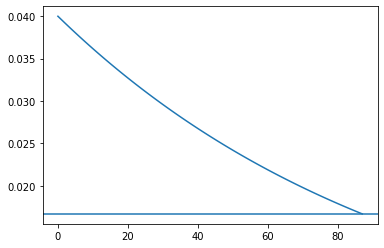

init eta: 0.04
min eta: 0.01668483519732882
##################################################
lmbda= 0.0001

eta= 0.04

n_eph= 88

batch_size= 10

decay_steps= 75000

decay_rate= 0.99

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 20)        520       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 40)          20040     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 40)         0         
 2D)                                                             
                                                                 
 f

In [ ]:
lmbda = 0.1 / 10 / 10 / 10

batch_size = 10
n_eph = 88

eta = 0.04

decay_steps = int(len(train_x) / batch_size) # 1 decay per epoch

decay_rate = 0.99

plot_decay(eta, decay_rate, n_eph)

a = train_cnn_sgd(
    lmbda, 
    batch_size, 
    n_eph, 
    eta, 
    decay_steps, 
    decay_rate, 
    train_x,
    train_y,
    val_x, 
    val_y, 
    test_x, 
    test_y
)


<h1>Speed Difference:<h1/>
<h2>>>>> local machine: 350s/epoch<h2/>
<h2>>>>> colab: 419s/epoch<h2/>
<h2>Time delta: -20%<h2/>
<h3>Note: Using the same random seed, I got slightly different result on colab.<h3/>